In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import mysql.connector


d = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "Shubham@2003",
                            database = "ecommerce")
cur = d.cursor()

# List all unique cities where customers are located.

In [93]:
query = """select distinct customer_city from customers"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [94]:
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""
cur.execute(query)
data = cur.fetchall()
"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 45101)

# Find the total sales per category.

In [95]:
query = """ select products.product_category category,
round(sum(payments.payment_value),2) sales
from products join orderitems
on products.product_id = orderitems.product_id
join payments
on payments.order_id = orderitems.order_id
group by category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns= ["category", "sales"])
df
                  

,category,sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


# Calculate the percentage of orders that were paid in installments.


In [96]:
query = """select (sum(case when payment_installments >= 1 then 1 
else 0 end))/count(*)*100 from Payments
"""
cur.execute(query)
data = cur.fetchall()
"the percentage of orders that were paid in installments is",  data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# Count the number of customers from each state.

   state  customer_count
0     SP           41746
1     SC            3637
2     MG           11635
3     PR            5045
4     RJ           12852
5     RS            5466
6     PA             975
7     GO            2020
8     ES            2033
9     BA            3380
10    MA             747
11    MS             715
12    CE            1336
13    DF            2140
14    RN             485
15    PE            1652
16    MT             907
17    AM             148
18    AP              68
19    AL             413
20    RO             253
21    PB             536
22    TO             280
23    PI             495
24    AC              81
25    SE             350
26    RR              46


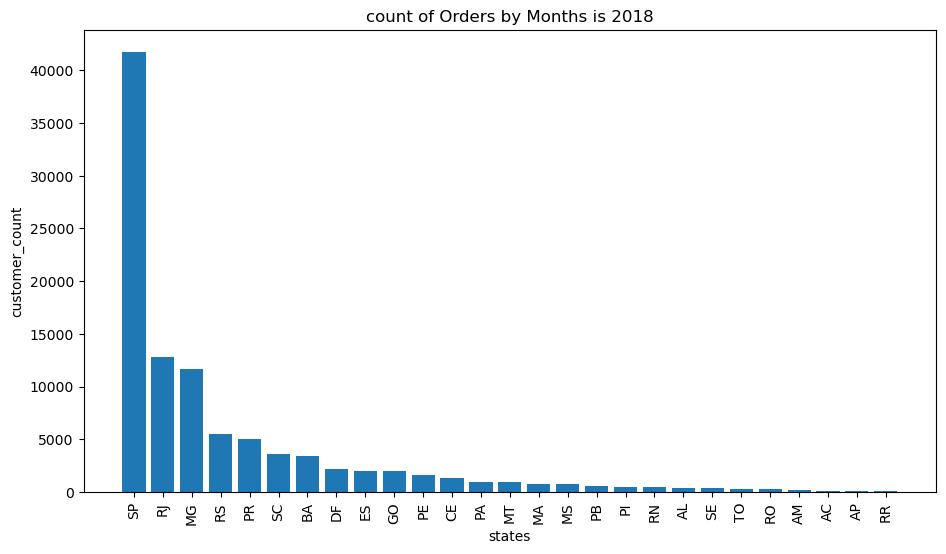

In [97]:
query = """ select customer_state, COUNT(*) AS customer_count
FROM customers
GROUP BY customer_state;
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["state", "customer_count"])
print(df)


df = pd.DataFrame(data,columns = ["state", "customer_count"])
df = df.sort_values(by = "customer_count", ascending = False)

plt.figure(figsize = (11,6))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation =90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("count of customer by states")
plt.title("count of Orders by Months is 2018")
plt.show()

# Calculate the number of orders per month in 2018.

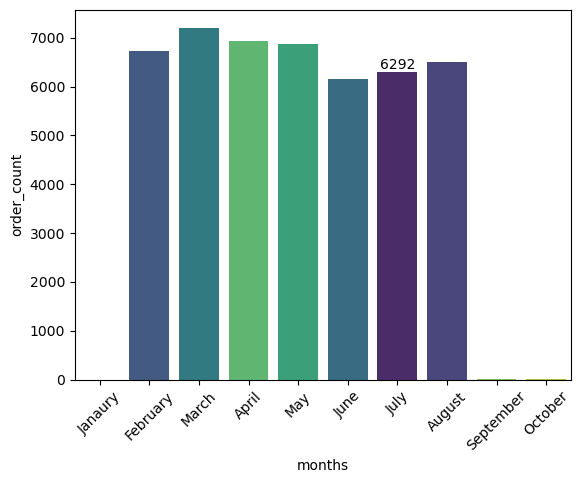

In [98]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns= ["months", "order_count"])
o = ["Janaury", "February", "March", "April", "May", "June", "July", "August", "September", "October"]

ax = sns.barplot(x=df["months"], y=df["order_count"], order=o, hue = df["months"], palette = "viridis")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.show()

# Find the average number of products per order, grouped by customer city.

In [99]:
query = """WITH count_per_order AS (
    SELECT 
        orders.order_id, 
        orders.customer_id, 
        COUNT(orderitems.order_id) AS oc  -- Alias added for COUNT
    FROM orders 
    JOIN orderitems ON orders.order_id = orderitems.order_id
    GROUP BY orders.order_id, orders.customer_id
)

SELECT 
    customers.customer_city, 
    ROUND(AVG(count_per_order.oc), 2) AS average_orders
FROM customers 
JOIN count_per_order ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city ORDER BY average_orders DESC;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer city", "average products/order"])
df.head(10)

,customer city,average products/order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Calculate the percentage of total revenue contributed by each product category.

In [100]:
query = """SELECT  
    UPPER(products.product_category) AS category,  
    ROUND((SUM(payments.payment_value) / (SELECT SUM(payment_value) FROM payments)) * 100, 2) AS sales_percentage  
FROM products  
JOIN orderitems ON products.product_id = orderitems.product_id  
JOIN payments ON payments.order_id = orderitems.order_id  
GROUP BY category ORDER BY sales_percentage DESC;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["category", "percent distribution"])
df

,category,percent distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


# Identify the correlation between product price and the number of times a product has been purchased.

In [101]:
import numpy as np

query = """select products.product_category,
count(orderitems.product_id) ,
round(avg(orderitems.price),2)
from products join orderitems
on products.product_id = orderitems.product_id
GROUP BY products.product_category;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["category", "order_count", "price"])


arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation between price and number of times a product has been purchased is", a[0][1])

the correlation between price and number of times a product has been purchased is -0.10631514167157562


#  Calculate the total revenue generated by each seller, and rank them by revenue.

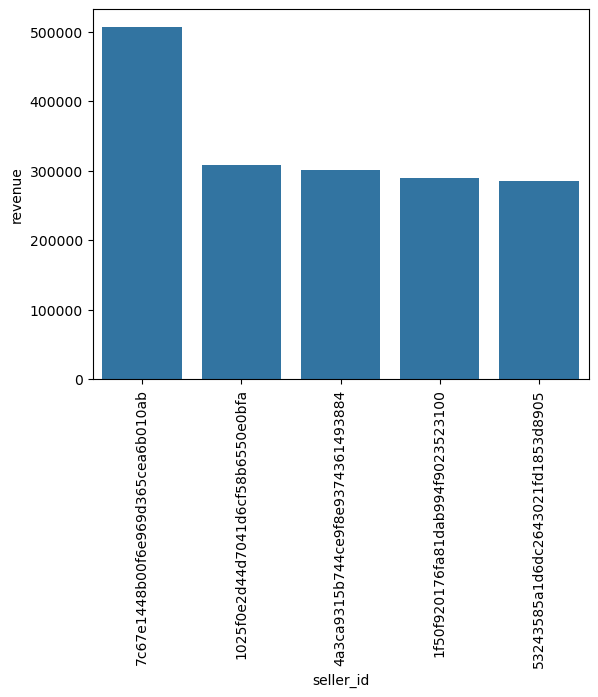

In [102]:
query = """SELECT *,
       DENSE_RANK() OVER(ORDER BY revenue DESC) AS rn 
FROM (
    SELECT orderitems.seller_id, 
           SUM(payments.payment_value) AS revenue  -- Added alias 'revenue'
    FROM orderitems
    JOIN payments ON orderitems.order_id = payments.order_id
    GROUP BY orderitems.seller_id
) AS a;

"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue" ,data = df)
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.


In [111]:
query = """SELECT customer_id, 
       order_purchase_timestamp,
       AVG(payment_value) OVER (
           PARTITION BY customer_id 
           ORDER BY order_purchase_timestamp
           ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
       ) AS mov_avg
FROM (
    SELECT orders.customer_id, 
           orders.order_purchase_timestamp, 
           payments.payment_value
    FROM payments 
    JOIN orders ON payments.order_id = orders.order_id
) AS a;

"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_id", "order_purchase_timestamp", "mov_avg"])
print(df.head(20))

                         customer_id order_purchase_timestamp      mov_avg
0   00012a2ce6f8dcda20d059ce98491703      2017-11-14 16:08:26   114.739998
1   000161a058600d5901f007fab4c27140      2017-07-16 09:40:32    67.410004
2   0001fd6190edaaf884bcaf3d49edf079      2017-02-28 11:06:43   195.419998
3   0002414f95344307404f0ace7a26f1d5      2017-08-16 13:09:20   179.350006
4   000379cdec625522490c315e70c7a9fb      2018-04-02 13:42:17   107.010002
5   0004164d20a9e969af783496f3408652      2017-04-12 08:35:12    71.800003
6   000419c5494106c306a97b5635748086      2018-03-02 17:47:40    49.400002
7   00046a560d407e99b969756e0b10f282      2017-12-18 11:08:30   166.589996
8   00050bf6e01e69d5c0fd612f1bcfb69c      2017-09-17 16:04:44    85.230003
9   000598caf2ef4117407665ac33275130      2018-08-11 12:14:35  1255.709961
10  0005aefbb696d34b3424dccd0a0e9fd0      2018-06-20 09:46:53   147.330002
11  00062b33cb9f6fe976afdcff967ea74d      2017-03-15 23:44:09    58.950001
12  00066ccbe787a588c52bd

# Calculate the cumulative sales per month for each year.

In [112]:
query = """SELECT years, 
       months, 
       payment_value, 
       SUM(payment_value) OVER (ORDER BY years, months) AS cumulative_sales 
FROM (
    SELECT YEAR(orders.order_purchase_timestamp) AS years,
           MONTHNAME(orders.order_purchase_timestamp) AS months,
           ROUND(SUM(payments.payment_value), 2) AS payment_value
    FROM orders 
    JOIN payments ON orders.order_id = payments.order_id
    GROUP BY years, months 
    ORDER BY years, months
) AS a;
;

"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["year", "month", "paymenr_value", "cumulative_sale"])
print(df.head(20))

    year      month  paymenr_value  cumulative_sale
0   2016   December          19.62            19.62
1   2016    October       59090.48         59110.10
2   2016  September         252.24         59362.34
3   2017      April      417788.03        477150.37
4   2017     August      674396.32       1151546.69
5   2017   December      878401.48       2029948.17
6   2017   February      291908.01       2321856.18
7   2017    January      138488.04       2460344.22
8   2017       July      592382.92       3052727.14
9   2017       June      511276.38       3564003.52
10  2017      March      449863.60       4013867.12
11  2017        May      592918.82       4606785.94
12  2017   November     1194882.80       5801668.74
13  2017    October      779677.88       6581346.62
14  2017  September      727762.45       7309109.07
15  2018      April     1160785.48       8469894.55
16  2018     August     1022425.32       9492319.87
17  2018   February      992463.34      10484783.21
18  2018    

# Calculate the year-over-year growth rate of total sales.

In [127]:
query = """WITH a AS (
    SELECT YEAR(orders.order_purchase_timestamp) AS years,
           ROUND(SUM(payments.payment_value), 2) AS payment_value
    FROM orders 
    JOIN payments ON orders.order_id = payments.order_id
    GROUP BY years
    ORDER BY years
)
SELECT years,
       payment_value AS sales,
       ROUND(((payment_value - LAG(payment_value, 1) OVER(ORDER BY years)) /
       LAG(payment_value, 1) OVER (ORDER BY years)) * 100, 2) AS previous_year_sales
FROM a;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["years", "sales", "yoy % growth"])
print(df.head())


                  

   years       sales  yoy % growth
0   2016    59362.34           NaN
1   2017  7249746.73       12112.7
2   2018  8699763.05          20.0


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [128]:
query = """WITH a AS (
    SELECT customers.customer_id,
           MIN(orders.order_purchase_timestamp) AS first_order
    FROM customers 
    JOIN orders ON customers.customer_id = orders.customer_id
    GROUP BY customers.customer_id
), 
b AS (
    SELECT a.customer_id, 
           COUNT(DISTINCT orders.order_purchase_timestamp) AS next_order
    FROM a 
    JOIN orders ON orders.customer_id = a.customer_id
               AND orders.order_purchase_timestamp > a.first_order
               AND orders.order_purchase_timestamp < DATE_ADD(a.first_order, INTERVAL 6 MONTH)
    GROUP BY a.customer_id
) 
SELECT 100 * (COUNT(DISTINCT a.customer_id) / COUNT(DISTINCT b.customer_id))
FROM a 
LEFT JOIN b ON a.customer_id = b.customer_id;

"""

cur.execute(query)
data = cur.fetchall()
data

[(None,)]

# Identify the top 3 customers who spent the most money in each year.

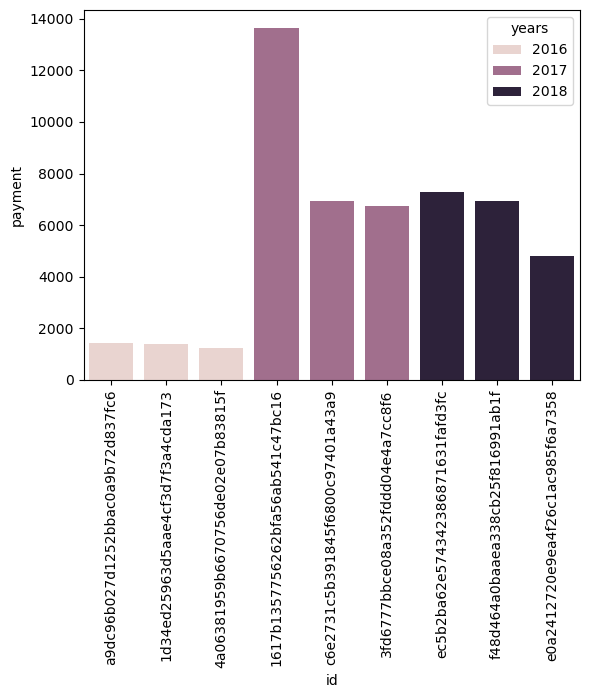

In [137]:
query = """SELECT order_year, customer_id, payment, rank_value
FROM (
    SELECT YEAR(orders.order_purchase_timestamp) AS order_year,
           orders.customer_id,
           SUM(payments.payment_value) AS payment,
           DENSE_RANK() OVER (PARTITION BY YEAR(orders.order_purchase_timestamp) 
                              ORDER BY SUM(payments.payment_value) DESC) AS rank_value
    FROM orders
    JOIN payments ON payments.order_id = orders.order_id
    GROUP BY YEAR(orders.order_purchase_timestamp), orders.customer_id
) AS a
WHERE rank_value <= 3;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "id", "payment", "rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()
                                
                  